<a href="https://colab.research.google.com/github/gpa-SP/training-data-analyst/blob/master/SegundaCorridaRevitalift%5BTv_de_Paga%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This script is not an officially supported Google product. It is provided without any guarantees, warranty, or liability to Google. 

Before using it, an engineer in the user's organization must review the code and ensure the company is comfortable with how it works.

It’s also important to note that Google doesn’t guarantee or promise any particular results from implementing this script. 

THIS SOFTWARE IS PROVIDED BY THE AUTHOR AND CONTRIBUTORS “AS IS” AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

Import all required libraries

In [ ]:
!pip install pycausalimpact
!pip install statsmodels
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.stats import truncnorm
import random
import math
import sys
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact
import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Introduce the file path to the baseline and the information of the number of queries that happened during the TV spots campaign.

In [ ]:
baselineFileName="/content/gdrive/My Drive/loreal/MX_2020-10-05__14-01_Revitalift_1_data_Loreal_MX_Revitalift_request_id_1_2020-10-05__14-01.csv"
campaignInfoFileName="/content/gdrive/My Drive/loreal/MX_2020-10-05__14-01_Revitalift_1_data_Loreal_MX_Revitalift_request_id_1_2020-10-05__14-01.csv"
commercialItinerary="/content/gdrive/My Drive/loreal/CORRIDA REVITALIFT AH SERUM OLA 1 TV PAGA.xlsx"

'''
Example code to sort the data.  
all_data = pd.read_csv("all_data.csv")
all_data = all_data.sort_values(['Date', 'Hour']) # This now sorts in date order
all_data.to_csv('all_data_sorted.csv', encoding='utf-8')
'''

'''
baselineFileName="Name of the file that conains the baseline information"
campaignInfoFileName="Name of the file that contains the information of queries that happened in the time of the campaign"
commercialItinerary="Name of the file that contains the information of the itinerary of TV spots"
'''


'\nbaselineFileName="Name of the file that conains the baseline information"\ncampaignInfoFileName="Name of the file that contains the information of queries that happened in the time of the campaign"\ncommercialItinerary="Name of the file that contains the information of the itinerary of TV spots"\n'

In [ ]:
### convertir a columna de fecha y setear el dia de inicio y fin

dataBaseLine=pd.read_csv(baselineFileName)
dataBaseLine['Date'] = pd.to_datetime(dataBaseLine['Date'],format='%Y-%m-%d')
dataBaseLine = dataBaseLine[["Date","Hour","num_of_queries"]]
dataBaseLine.head()

,Date,Hour,num_of_queries
0,2020-07-11,4,0.0024
1,2020-07-07,22,0.0572
2,2020-07-31,8,0.0547
3,2020-07-16,13,0.1194
4,2020-07-25,21,0.1915


In [ ]:
start_date = '2020-07-05'
end_date = '2020-07-12'

filter = (dataBaseLine['Date'] >= start_date) & (dataBaseLine['Date'] <= end_date)
dataRealLine = dataBaseLine[filter]
dataBaseLine['Date'] = dataBaseLine['Date'].dt.date.astype(str)
dataRealLine['Date'] = dataRealLine['Date'].dt.date.astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
dataCommercials=pd.read_excel(commercialItinerary) #, encoding = "ISO-8859-1"
dataCommercials['Date'] = pd.to_datetime(dataCommercials['Date'],format='%Y-%m-%d')
dataCommercials['Date'] = dataCommercials['Date'].dt.date
dataCommercials.head()

,Channel,Date,Start Time {Av(Tm)},Master Program,Length {Sum},Description,Fringe,Position,Rch# Target Ibope,Rch# Target nacional,Costo por spot
0,TLNOVELAS IZZI,2020-07-13,14:16:27,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.0,0.0,618.82
1,TLNOVELAS IZZI,2020-07-13,15:09:23,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.0,0.0,618.82
2,TLNOVELAS IZZI,2020-07-13,16:45:25,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,SEGUNDA POSICION,0.0,0.0,618.82
3,TLNOVELAS IZZI,2020-07-13,17:40:26,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,TERCERA POSICION,0.0,0.0,618.82
4,DE PELICULA IZZI,2020-07-13,13:58:24,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,ULTIMA POSICION,0.0,0.0,618.82


In [ ]:
dataCommercials.columns

Index(['Channel', 'Date', 'Start Time {Av(Tm)}', 'Master Program',
       'Length {Sum}', 'Description', 'Fringe', 'Position',
       'Rch# Target Ibope', 'Rch# Target nacional', 'Costo por spot'],
      dtype='object')

In [ ]:
#dataBaseLine=pd.read_csv(baselineFileName) #Raw information from baseline
#dataRealLine=pd.read_csv(campaignInfoFileName) #Raw information from dates of the campaign
#dataCommercials=pd.read_csv(commercialItinerary, encoding = "ISO-8859-1")

dataBaseLine.columns=["Date","Hour","num_of_queries"]
dataRealLine.columns=["Date","Hour","num_of_queries"]
dataCommercials.columns=["Channel","Date","Start Time","Master Program","Length","Description","Fringe","Position","Rch Target Ibope", "Rch Target nacional","Costo por spot"]

'''
dataBaseLine.columns=["request_id","Date","Hour","num_of_queries"]
dataRealLine.columns=["request_id","Date","Hour","num_of_queries"]
'''

print("Raw data Assigned")



Raw data Assigned


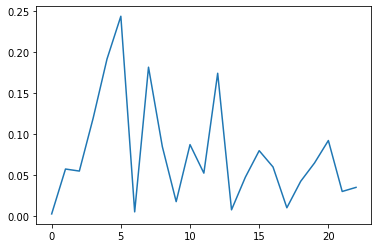

In [ ]:
dataBaseLine["num_of_queries"][0:23].plot()

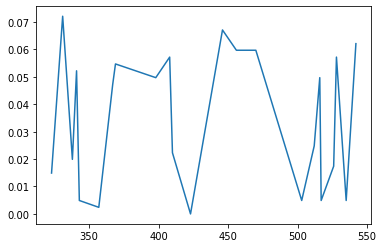

In [ ]:
dataRealLine["num_of_queries"][24:47].plot()

In [ ]:
dataBaseLine # Execute to preview data

,Date,Hour,num_of_queries
0,2020-07-11,4,0.0024
1,2020-07-07,22,0.0572
2,2020-07-31,8,0.0547
3,2020-07-16,13,0.1194
4,2020-07-25,21,0.1915
...,...,...,...
2227,2020-08-12,20,0.1243
2228,2020-08-19,14,0.0746
2229,2020-09-01,2,0.0074
2230,2020-09-08,12,0.0895


In [ ]:
dataRealLine # Execute to preview data

,Date,Hour,num_of_queries
0,2020-07-11,4,0.0024
1,2020-07-07,22,0.0572
21,2020-07-12,15,0.0298
56,2020-07-08,9,0.0572
58,2020-07-11,15,0.0547
...,...,...,...
2173,2020-07-07,4,0.0024
2174,2020-07-07,2,0.0024
2195,2020-07-10,21,0.0820
2215,2020-07-08,14,0.0497


In [ ]:
dataCommercials # Execute to preview data

,Channel,Date,Start Time,Master Program,Length,Description,Fringe,Position,Rch Target Ibope,Rch Target nacional,Costo por spot
0,TLNOVELAS IZZI,2020-07-13,14:16:27,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.00,0.0,6.188200e+02
1,TLNOVELAS IZZI,2020-07-13,15:09:23,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.00,0.0,6.188200e+02
2,TLNOVELAS IZZI,2020-07-13,16:45:25,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,SEGUNDA POSICION,0.00,0.0,6.188200e+02
3,TLNOVELAS IZZI,2020-07-13,17:40:26,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,TERCERA POSICION,0.00,0.0,6.188200e+02
4,DE PELICULA IZZI,2020-07-13,13:58:24,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,ULTIMA POSICION,0.00,0.0,6.188200e+02
...,...,...,...,...,...,...,...,...,...,...,...
945,DISTRITO COMEDIA IZZI,2020-08-09,16:04:15,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,ULTIMA POSICION,2613.44,0.0,6.188200e+02
946,TELEMUNDO IZZI,2020-08-09,09:51:58,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,A,PRIMERA POSICION,2613.44,0.0,2.800000e+03
947,TELEMUNDO IZZI,2020-08-09,12:12:00,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,PRIMERA POSICION,2613.44,0.0,2.800000e+03
948,TELEMUNDO IZZI,2020-08-09,18:12:42,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,PRIMERA POSICION,2613.44,0.0,4.400000e+03


In [ ]:
for column in dataCommercials.columns:
  dataCommercials[column] = dataCommercials[column].astype(str)
dataCommercials.info()

dataCommercials['Start Time'] = dataCommercials['Start Time'].str.replace('1900-01-01 ','')
dataCommercials['Start Time'] = dataCommercials['Start Time'].str.split(':')#.str[:-1]
dataCommercials['Start Time'] = dataCommercials['Start Time'].apply(lambda x: ':'.join(x)).astype(str)
dataCommercials.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Channel              950 non-null    object
 1   Date                 950 non-null    object
 2   Start Time           950 non-null    object
 3   Master Program       950 non-null    object
 4   Length               950 non-null    object
 5   Description          950 non-null    object
 6   Fringe               950 non-null    object
 7   Position             950 non-null    object
 8   Rch Target Ibope     950 non-null    object
 9   Rch Target nacional  950 non-null    object
 10  Costo por spot       950 non-null    object
dtypes: object(11)
memory usage: 81.8+ KB


,Channel,Date,Start Time,Master Program,Length,Description,Fringe,Position,Rch Target Ibope,Rch Target nacional,Costo por spot
0,TLNOVELAS IZZI,2020-07-13,14:16:27,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.0,0.0,618.82
1,TLNOVELAS IZZI,2020-07-13,15:09:23,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,CUALQUIER OTRA POSICION,0.0,0.0,618.82
2,TLNOVELAS IZZI,2020-07-13,16:45:25,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,SEGUNDA POSICION,0.0,0.0,618.82
3,TLNOVELAS IZZI,2020-07-13,17:40:26,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,TERCERA POSICION,0.0,0.0,618.82
4,DE PELICULA IZZI,2020-07-13,13:58:24,n.a,00:00:20,SRA ACIDO NVO HIDRAT 20S,AA,ULTIMA POSICION,0.0,0.0,618.82


In [ ]:
#Input validation the columns and column types should be in an strict format

if(len(dataBaseLine)<24):
  raise Exception("The number of rows for the baseline information should have at least 24 elements")

if(len(dataRealLine)<24):
  raise Exception("The number of rows for the information of the campaign should have at least 24 elements")

if(len(dataCommercials)<10):
  raise Exception("The number of rows for the itinerary information should have at least 10 elements")


if(len(dataBaseLine.columns)!=3):
  raise Exception("The baseline information should have only 3 columns")
if(len(dataRealLine.columns)!=3):
  raise Exception("The baseline information should have only 3 columns")
dataBaseLineTypes=dataBaseLine.dtypes
dataRealLineTypes=dataRealLine.dtypes


#if(not(dataBaseLineTypes["Date"]==np.object and dataBaseLineTypes["Hour"]==np.int64 and dataBaseLineTypes["num_of_queries"]==np.int64)):
#  raise Exception("The baseline information should have [String,String,Float] data types")

#if(not(dataRealLineTypes["Date"]==np.object and dataRealLineTypes["Hour"]==np.int64 and dataRealLineTypes["num_of_queries"]==np.int64)):
#  raise Exception("The baseline information should have [String,String,Float] data types")

'''
if(not(dataBaseLineTypes["request_id"]==np.object and dataBaseLineTypes["Date"]==np.object and dataBaseLineTypes["Hour"]==np.int64 and dataBaseLineTypes["num_of_queries"]==np.float64)):
  raise Exception("The baseline information should have [String,String,String,Float] data types")

if(not(dataRealLineTypes["request_id"]==np.object and dataRealLineTypes["Date"]==np.object and dataRealLineTypes["Hour"]==np.int64 and dataRealLineTypes["num_of_queries"]==np.float64)):
  raise Exception("The baseline information should have [String,String,String,Float] data types")
'''

if(len(dataCommercials.columns) != 11): 
    raise Exception("The commercial information should have only 12 columns") 


dataCommercialTypes = dataCommercials.dtypes

if(not(dataCommercialTypes["Channel"] == np.object and dataCommercialTypes["Date"] == np.object and dataCommercialTypes["Start Time"] == np.object and dataCommercialTypes["Master Program"] == np.object and dataCommercialTypes["Length"] == np.object and dataCommercialTypes["Description"] == np.object and dataCommercialTypes["Fringe"] == np.object  and dataCommercialTypes["Position"] == np.object and dataCommercialTypes["Rch Target Ibope"] == np.object and dataCommercialTypes["Rch Target nacional"] == np.object and dataCommercialTypes["Costo por spot"] == np.object)):
  raise Exception('The data type for all columns in dataCommercials must be of type String')

for startTime in dataCommercials["Start Time"]:
  timeParts = startTime.split(":")




  if (not((len(timeParts) == 3) and (isinstance(int(timeParts[0]), int)) and (isinstance(int(timeParts[1]), int)))):
    raise ValueError("Incorrect Start Time format. The Start Time must be Hour:Minute")

for date in dataBaseLine["Date"]:
  try:
    datetime.datetime.strptime(date, '%Y-%m-%d')
  except ValueError:
    raise ValueError("Incorrect data format. The Date must be YYYY-MM-DD")



for date in dataRealLine["Date"]:
  try:
    datetime.datetime.strptime(date, '%Y-%m-%d')
  except ValueError:
    raise ValueError("Incorrect data format, The Date must be YYYY-MM-DD")



In [ ]:
#Definition to transform the hourly data to simulated minutes

def hoursToMin(listHours):
    minData=[] #In this array you will store the minute by minute simulation
    
    for hour in listHours:
        queriesEnHora=hour 
        
        promedio=queriesEnHora/60.0

        desviacionAjustada=promedio/3.0

        data = np.random.normal(promedio,desviacionAjustada,60)   
        
        minData.append(data)
    
    return minData #You return a list of lists in which each interior list is a range of simulated minutes in a given hour 


In [ ]:

def breakIntoDays(baseline):
    baselineDateSeparation=[] #Este es un arreglo de columnas que podemos procesar

    distinctDaysBaseline=baseline[["Date"]].values.flatten().tolist()

    distinctDaysBaseline = list(dict.fromkeys(distinctDaysBaseline)) #Aqui ya tenemos todas distintas fechas del baseline

    #iteramos la lista de fechas distintas y categorizamos el baseline
    for i in distinctDaysBaseline:
        daySlice=baseline.loc[baseline["Date"]==i]

        baselineDateSeparation.append(daySlice)
        
    return baselineDateSeparation

In [ ]:
def stringToWeekDay(date):
    date_time_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    return date_time_obj.weekday()

In [ ]:
def markDayOfWeek(baselineDateSeparation):
    for day in baselineDateSeparation:
        day["weekDay"] = day.apply(lambda row: stringToWeekDay(row["Date"]), axis=1)
    return baselineDateSeparation.copy()

In [ ]:
#convertimos cada dia del baseline en minutos
def baseDayToMins(baselineDateSeparation):
    baselineMinutesPerDay=[]
    for i in baselineDateSeparation:
        listHours=i[["num_of_queries"]].values
        minutesOfADay=np.array(hoursToMin(listHours)).flatten()
        baselineMinutesPerDay.append(minutesOfADay)
    return baselineMinutesPerDay #Aqui tenemos un array por dia con su numero de minutos

In [ ]:
def horarioAMinuto(horario):
    splitHorario=horario.split(":")
    minutoInicio=(int(splitHorario[0])*60)+int(splitHorario[1])
    return minutoInicio

In [ ]:
def markStartTimeCommercial(commercials):
    
    commercials["minutoInicio"] = commercials.apply(lambda row: horarioAMinuto(row["Start Time"]), axis=1)
    
    
    return commercials.copy()

In [ ]:
def studyInit(inicio, preperiod):
    if((inicio-(preperiod*60))>=0):
        return (inicio-(preperiod*60))
    else:
        return 0

In [ ]:
def studyFin(inicio, postperiod):
    if((inicio+(postperiod*60))>=1440):
        return 1439
    else:
        return (inicio+(postperiod*60))

In [ ]:
def markTimesStudyCommercial(commercials,preperiod,postperiod):
    
    commercials["studyInit"]=commercials.apply(lambda row: int(studyInit(row["minutoInicio"],preperiod)), axis=1)
    commercials["studyFin"]=commercials.apply(lambda row: int(studyFin(row["minutoInicio"],postperiod)), axis=1)
    
    #commercials['studyInit'] =  (commercials['minutoInicio'] -(preperiod*60) )
    #commercials['studyFin'] =  (commercials['minutoInicio'] +(postperiod*60) )
    return commercials

In [ ]:
def getYIndex(commercial,reallineDateSeparation):
    y=0
    index=0
    for day in reallineDateSeparation:
        #print(day["Date"].values[0])
        #print(commercial)
        
        
        if(day["Date"].values[0]==commercial):
            y=index
            return y
        index+=1
        
    return y

In [ ]:
def getRealIndex(markedCommercials,reallineDateSeparation):
    #por cada renglon llamamos una funcion que nos va a decir en que indice de realline data separation esta el dia real en que se dio el comercial
    markedCommercials["YIndex"]=markedCommercials.apply(lambda row: getYIndex(row["Date"],reallineDateSeparation), axis=1)
    return markedCommercials

In [ ]:
#Definimos la funcion
def completeCausalImpact(baseline, commercials, realine):
    np.random.seed(12345)
    baselineDateSeparation=breakIntoDays(baseline) #Aqui ya tenemos la separacion por dia del baseline
    #print(baselineDateSeparation)


 #Vamos a recorrer cada seccion y generar una lista con el dia de la semana que es y se la agregamos como col
    baselineDateSeparation=markDayOfWeek(baselineDateSeparation) #Aqui ya cada dia tiene si dia de la semana que le toca
    #print(baselineDateSeparation)



    #print(np.sum(baselineDateSeparation[15]['num_of_queries']))

    #ahora generamos los minutos de cada dia del baseline en otro arreglo de arreglos
    #Se va a vincular a la separacion de dias por tener el mismo indice
    baselinesInMins=baseDayToMins(baselineDateSeparation)# aqui ya tenemos todo el baseline en arreglos de minutos
    #print(baselinesInMins)


    ########################################################################
    #Vamos a procesar de manera similar los datos que hay en el tiempo que sucedieron los anuncios
    realineDateSeparation=breakIntoDays(realine)
    #print(realineDateSeparation)
    reallineDateSeparation=markDayOfWeek(realineDateSeparation)
    #print(realineDateSeparation)
    realinesInMins=baseDayToMins(reallineDateSeparation)
    #print(np.sum(realinesInMins[1]))





    markedCommercials=markStartTimeCommercial(commercials) #Aqui ya tenemos el dataset de comerciales pero queremos calcular y agregar los rangos manejando los casos extremos
    #print(markedCommercials)



    markedCommercials=markTimesStudyCommercial(markedCommercials,4.5,0.6) #Aqui ya tenemos los comerciales con sus rangos para probar
    #print(markedCommercials)



    #queremos calcular el real index que le corresponde que va a ser Y
    markedCommercials=getRealIndex(markedCommercials,reallineDateSeparation)#Aqui ya sabemos el indice de reallineDateSeparation al que corresponde cada comercial, vamos a sacar las Y
    print(markedCommercials)
    #print(reallineDateSeparation[27])






    objects=[]
    pvalues=[]
    impact=[]
    relativeEffectLow=[]
    relativeEffectHigh=[]

    for index , commercial in markedCommercials.iterrows():

        #print(commercial)


        #creamos un diccionario y le asignamos y
        
        #print("Yindex")
        #print(commercial["YIndex"])
        #print("init")
        #print(commercial["studyInit"])
        #print("fin")
        #print(commercial["studyFin"])
        
        
        
        
        dic={"y":realinesInMins[commercial["YIndex"]][commercial["studyInit"]:commercial["studyFin"]]}
        
        #aqui ya tenemos la y para cada comercial ahora vamos a calcular las X1,X2,X3... para cada comercial y lo vamos agregando al objeto dic
        xs=["y"]
        #para cada baseline guardo el indice y lo voy poniendo en xs mas la X y voy agregando a dic el key value con X que toque y su baseline recortado como arriba
        indice=0
        for baseline in baselinesInMins:
            xstring="X"+str(indice)
            xs.append(xstring)
            dic[xstring]=baseline[commercial["studyInit"]:commercial["studyFin"]]
            indice+=1
        objects.append(dic) ###Aqui nos quedamos
        #print(xs)
        
        #finalmente vamos a ejecutar causal impact en cada comercial para ver el impacto
        
        #print("y")
        #print(len(dic["y"]))
        #print("X0")
        #print(len(dic["X0"]))
        
        #print("indice")
        #print(index)
        
        #print("studyInit")
        #print(commercial["studyInit"])
        #print("studyFin")
        #print(commercial["studyFin"])
        
        
        
        
        
        
        try:
        
            dataCausal = pd.DataFrame(dic, columns=xs)
            pre_period = [0, 240]
            post_period = [241, len(dic["y"])-1]

            ci = CausalImpact(dataCausal, pre_period, post_period, prior_level_sd=None)
            pvalue=ci.p_value
            imp=ci.summary_data["cumulative"][4]
            
            if(pvalue<0.05):
                pvalues.append(pvalue)
                impact.append(imp)
                relativeEffectLow.append(ci.summary_data["cumulative"][8])
                relativeEffectHigh.append(ci.summary_data["cumulative"][9])
            else:
                pvalues.append(pvalue)
                impact.append(0)
                relativeEffectLow.append(0)
                relativeEffectHigh.append(0)
            #print(ci.summary())
            #print(ci.summary(output='report'))
            #ci.plot()
        except:
            pvalues.append(0)
            impact.append(0)
            relativeEffectLow.append(0)
            relativeEffectHigh.append(0)
            continue
        print(index)
        print(pvalues)
        print(impact)
        
            
    #print(pvalues)
    markedCommercials["pvalue"]=pvalues
    markedCommercials["impact"]=impact
    markedCommercials["relEffectHigh"]=relativeEffectHigh
    markedCommercials["relEffectLow"]=relativeEffectLow
    
    print(type(markedCommercials))
    print(markedCommercials)
    markedCommercials.to_csv(r"timefix_offus_olauno_like_revitalift.csv")
    return markedCommercials
        
            
    
    
    #Ahora vamos a tomar el indice que corresponde al dia del comercial en realineDateSeparation tomamos ese indice de realinesInMins
    #tomamos el slice que viene en markedCommercials en studyinit y studyfin y ese será Y
    
    
    
    #Para las X vamos a crear un slice con lo que viene en markedCommercials cada slice va a ser un baseline X1,X2,X3...
    #armamos el dataframe con los resultados y corremos el modelo
    




In [ ]:
#ejecutamos la funcion
result = completeCausalImpact(dataBaseLine, dataCommercials, dataRealLine)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


                   Channel        Date Start Time  ... studyInit studyFin YIndex
0           TLNOVELAS IZZI  2020-07-13   14:16:27  ...       586      892      0
1           TLNOVELAS IZZI  2020-07-13   15:09:23  ...       639      945      0
2           TLNOVELAS IZZI  2020-07-13   16:45:25  ...       735     1041      0
3           TLNOVELAS IZZI  2020-07-13   17:40:26  ...       790     1096      0
4         DE PELICULA IZZI  2020-07-13   13:58:24  ...       568      874      0
..                     ...         ...        ...  ...       ...      ...    ...
945  DISTRITO COMEDIA IZZI  2020-08-09   16:04:15  ...       694     1000      0
946         TELEMUNDO IZZI  2020-08-09   09:51:58  ...       321      627      0
947         TELEMUNDO IZZI  2020-08-09   12:12:00  ...       462      768      0
948         TELEMUNDO IZZI  2020-08-09   18:12:42  ...       822     1128      0
949                    nan         nan   16:34:57  ...       724     1030      0

[950 rows x 15 columns]
<cl

In [ ]:
result['relEffectLow'].unique()

array([0])